In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [4]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
linkRates

#Elink ve Slink'in ne?

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,12,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
1,13,240.2424,7.0,1,3.333333,4.666667,314.0,3,False,7.687757,1098.250971
2,14,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,15,142.2112,5.0,1,6.500000,6.500000,366.5,4,False,4.550758,910.151680
4,16,176.1495,6.0,1,7.000000,6.000000,374.0,5,False,5.636784,939.464000
...,...,...,...,...,...,...,...,...,...,...,...
105,894,157.3610,8.0,29,2.333333,3.666667,7465.0,3,True,5.035552,629.444000
106,907,186.1277,8.0,30,4.000000,2.000000,7746.0,3,True,5.956086,744.510800
107,920,170.0694,9.0,30,1.000000,4.000000,7700.0,3,True,5.442221,604.691200
108,922,169.7657,9.0,30,3.000000,4.000000,7732.0,3,True,5.432502,603.611378


In [5]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")




There is a total of 1508 lpGBT links:
 - 1288 singles, and
 - 110 doubles (with one ECOND straddling the pair)



In [6]:

sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates


,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
1158,1378,12.1890,5.0,40,15.0,2.0,10482.0,1,False,0.390048,78.009600
1160,1380,12.1951,5.0,40,15.0,4.0,10484.0,1,False,0.390243,78.048640
1162,1382,12.1958,5.0,40,15.0,6.0,10486.0,1,False,0.390266,78.053120
1159,1379,12.1976,5.0,40,15.0,3.0,10483.0,1,False,0.390323,78.064640
1164,1384,12.1992,5.0,40,15.0,8.0,10488.0,1,False,0.390374,78.074880
...,...,...,...,...,...,...,...,...,...,...,...
40,192,461.9141,13.0,7,3.0,0.0,1840.0,3,True,14.781251,1137.019323
13,62,467.5174,13.0,3,3.0,3.0,819.0,3,True,14.960557,1150.812062
12,60,467.6358,13.0,3,3.0,0.0,816.0,3,True,14.964346,1151.103508
24,124,483.2248,13.0,5,3.0,0.0,1328.0,3,True,15.463194,1189.476431


In [7]:
assert( len(sortedRates)%2 == 0 )

In [8]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)


In [9]:
nFPGA = 16 #max=28
#runNumber = 3 #max=4
splitNumber=8

warmStart=False
hardStart=True

#---------------------------------------------------

nGBTSingles = int((1288*nFPGA)/nFPGA)
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = int((110*nFPGA)/nFPGA)
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
#maxSlinkRate = 300
nSlinks = nFPGA*12  #336

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles
maxGBTsPerSlink = 12
SlinkPerFPGA = 12



In [10]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")




Toy problem parameters:
- 1398 lpGBT inputs.
  - 1288 lpGBT singles, and
  - 110 lpGBT doubles.
- 192 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.


 - 16 FPGAs and
 - 12 Slinks served by each FPGA.



In [11]:
def split_dict_equally(input_dict, chunks=2):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list


In [12]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
if nFPGA==nFPGA:
    medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(nGBTSingles/3):-1*int(nGBTSingles/3)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTSingles/3):].to_dict()

lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
if nFPGA==nFPGA:
    medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

#------------------------------------------------------------

lowS_1={}
medS_1={}
highS_1=highS

lowD_1=lowD
medD_1=medD
highD_1=highD

    
#------------------------------------------------------------

if mode=='LtoH':
    medS_1.update(highS_1)
    lowS_1.update(medS_1)
    
    medD_1.update(highD_1)
    lowD_1.update(medD_1)
    
    singleGBTRates_1 = lowS_1
    doubleGBTRates_1 = lowD_1
if mode=='HtoL':
    medS_1.update(lowS_1)
    highS_1.update(medS_1)
    
    medD_1.update(lowD_1)
    highD_1.update(medD_1)
    
    singleGBTRates_1 = highS_1
    doubleGBTRates_1 = highD_1
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]

print(len(singleGBTRates_1))
print(singleGBTRates_1)
print(len(doubleGBTRates_1))
print(doubleGBTRates_1)



429
{364: 101.6522, 712: 101.7297, 775: 101.7515, 774: 101.75710000000001, 703: 101.79149999999998, 366: 101.8058, 616: 101.85329999999999, 617: 101.9138, 1024: 102.2541, 1025: 102.35079999999999, 1010: 102.49589999999998, 1011: 102.5005, 333: 102.8258, 330: 102.91199999999999, 331: 102.9726, 542: 102.97670000000001, 543: 103.01419999999999, 332: 103.0669, 1119: 103.1788, 1116: 103.2344, 727: 103.2387, 725: 103.3066, 759: 103.6225, 757: 103.7158, 217: 103.9479, 648: 103.98109999999998, 649: 103.9851, 638: 104.067, 216: 104.11319999999999, 373: 104.1889, 639: 104.1986, 372: 104.23060000000001, 914: 104.66792, 915: 104.75259, 553: 104.79920000000001, 552: 104.86320000000002, 969: 104.9403, 26: 104.99390000000001, 970: 105.05099999999999, 27: 105.0616, 956: 105.6527, 955: 105.7606, 457: 105.8179, 455: 105.9285, 454: 105.9863, 456: 106.0684, 663: 106.193, 241: 106.2282, 661: 106.2782, 240: 106.3634, 695: 106.52770000000001, 693: 106.5575, 482: 106.587, 510: 106.64569999999999, 511: 106.712

In [13]:
totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in doubleGBTRates_1.values()]) )

In [14]:
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /len(doubleGBTRates_1)+len(doubleGBTRates_1)}
Average Slink rate: {totalRate / nSlinks}
""")



Total lpGBT rate: 100269.13486999997
Average lpGBT rate: 1021.5375897272725
Average Slink rate: 522.2350774479165



In [15]:
#maxSlinkRatePyomo = (totalRate / nSlinks)*1.8
maxSlinkRatePyomo = 600
#maxSlinkRatePyomo = (totalRate / (len(doubleGBTRates_1)+len(singleGBTRates_1)))*1.5
maxSlinkRateGekko = (totalRate / nSlinks)*1.4
print("maxSlinkRatePyomo: ",maxSlinkRatePyomo)
#print("maxSlinkRateGekko: ",maxSlinkRateGekko)
avSlinkEvSize = totalRate/nSlinks



maxSlinkRatePyomo:  600


In [73]:
total_sum=0
for i in linkRates["EvSize"]:
   
    total_sum += i#.apply( lambda x : 

In [76]:
Average_lpGBT_rate=total_sum/1398


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/pytho

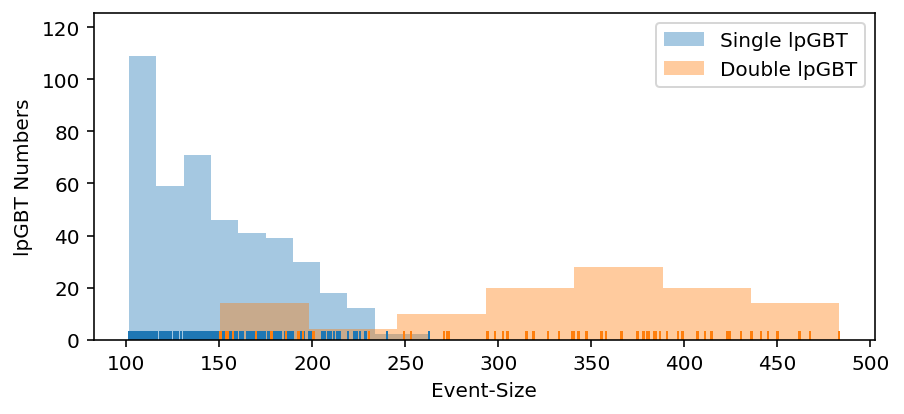

In [81]:
f, ax = plt.subplots(figsize=(7, 3))
ax.set_xlabel('Event-Size')
ax.set_ylabel("lpGBT Numbers")
sns.distplot(
    [i for i in singleGBTRates_1.values()],
    kde=False,
    rug=True,
    label='Single lpGBT'
    )
#plt.annotate('Average', xy=(Average_lpGBT_rate,0), xytext=(Average_lpGBT_rate, 30),  ha='center',
             #arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))

sns.distplot(
    [i for i in doubleGBTRates_1.values()],
    kde=False,
    rug=True,
    label='Double lpGBT'
    )
#plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             #arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()
plt.savefig("new lpgbt rate plot for thesis")



In [19]:
from dataclasses import dataclass
@dataclass
class Slink:
    totalEvSize: float
    linkList: list

from operator import attrgetter
def assign_link(link, Slinks):
    Slinks.sort(key=attrgetter('totalEvSize'))
    target = Slinks[0]
    target.linkList.append(link[0])
    target.totalEvSize += link[1]
    return Slinks

Slinks = [Slink(totalEvSize=0, linkList=[]) for _ in range(nSlinks)]
#for link in sortedLinkRates.itertuples(name='Link', index=False):
#    Slinks = assign_link(link, Slinks)

lpGBTs={}
lpGBTs.update(doubleGBTRates_1)
lpGBTs.update(singleGBTRates_1)
lpGBTs={k: v for k, v in sorted(lpGBTs.items(), key=lambda item: item[1],reverse=True)}
for link in lpGBTs.items():
    Slinks = assign_link(link, Slinks)

SlinkTotals = pd.DataFrame(data=[ Slink.totalEvSize for Slink in Slinks ], columns=['EvSize'])
#print(SlinkTotals)


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


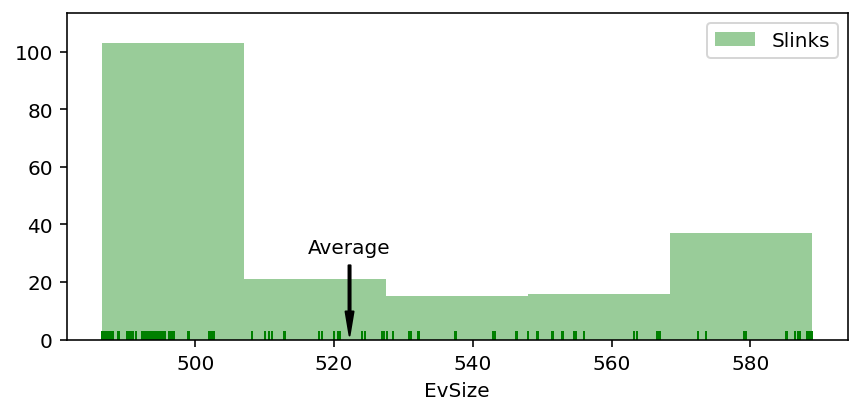

In [20]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    SlinkTotals['EvSize'],
    kde=False,
    rug=True,
    color = 'g',
    label='Slinks'
    )
plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()




In [16]:
model = pyo.ConcreteModel()

In [17]:
Single1=[str(k) for k in singleGBTRates_1.keys()]
Double1 = [str(k) for k in doubleGBTRates_1.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
#print(Single1)
#print(Double1)
#print(Slink)
#print(FPGA)


In [18]:
model.GKSingles1 = pyo.Var(Single1, Slink, initialize = 0, within = pyo.Binary)
model.GKDoubles1 = pyo.Var(Double1, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)



In [19]:
if warmStart==True or hardStart==True:
    i=1
    for slink in Slinks:
        #print(slink.linkList)
        for link in slink.linkList:
            #print(link)
            if str(link) in Single1:
                model.GKSingles1[str(link),str(i)]=1
            elif str(link) in Double1:
                model.GKDoubles1[str(link),str(i)]=1
        i+=1


In [20]:
def SetNumberofLinks1(model, i):
    return sum([ model.GKSingles1[i, j] for j in Slink ]) == 1
    
def SetNumberofLinks2(model, i):
    return sum([ model.GKDoubles1[i, j] for j in Slink ]) == 1
    
def SetNumberofLinks3(model, i):
    return sum([ model.GKSlinks[i, j] for j in FPGA ]) == 1
    
model.linkCutS1 = pyo.Constraint(Single1, rule = SetNumberofLinks1)
model.linkCutD1 = pyo.Constraint(Double1, rule = SetNumberofLinks2)
model.linkCutSK = pyo.Constraint(Slink, rule = SetNumberofLinks3)


In [21]:
def maxGBTs(model, j):
    return sum([ model.GKSingles1[i, j] for i in Single1 ]) + 2*sum([ model.GKDoubles1[i, j] for i in Double1 ]) <= maxGBTsPerSlink

def PerFPGA(model, j):   
    return sum([ model.GKSlinks[i, j] for i in Slink ]) == SlinkPerFPGA 

model.maxlpGBT = pyo.Constraint(Slink, rule = maxGBTs)
model.PerFPGA = pyo.Constraint(FPGA,  rule = PerFPGA)



In [22]:
def RateCut(model, j):   
    return sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j] for i in Double1 ]) <= maxSlinkRatePyomo 
        
model.ratelimit = pyo.Constraint(Slink, rule = RateCut)


In [23]:
GKavSlinkRate = (totalRate/nSlinks)
#print(GKavSlinkRate)


In [24]:
def OBJrule(model):
    GKslinkRatesVariance=0
    for j in Slink:
        GKslinkRates=sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j] for i in Double1 ]) 
        GKslinkRatesVariance +=  abs(GKslinkRates-GKavSlinkRate)  
    GKslinkRatesStDev = (GKslinkRatesVariance / (nSlinks-1))
    return GKslinkRatesStDev
model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)



In [25]:
if hardStart==False:
    #pyo.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt', tee=True)
    pyo.SolverFactory('./PyomoSolvers/couenne-linux64/couenne').solve(model, tee=False)
    #pyo.SolverFactory('./PyomoSolvers/SCIPOptSuite-7.0.1-Darwin/bin/scip').solve(model, tee=True)
    #pyo.SolverFactory('./PyomoSolvers/apopt-master/apopt.py').solve(model, tee=True) 



In [26]:
model.GKSingles1.fix()
model.GKDoubles1.fix()


In [27]:
with open('./ScriptRuns/'+str(nFPGA)+'lowsFPGA_run1.pkl', mode='wb+') as file:
    cloudpickle.dump(model, file)


In [33]:
#with open('./ScriptRuns/mediums3FPGA_run2_part1.pkl', mode='rb') as file:
    #model = cloudpickle.load(file)

In [34]:
#with open('./ScriptRuns/lows28FPGA_run2_part_thershold6700.pkl', mode='rb') as file:
    #model = cloudpickle.load(file)

In [35]:
 #with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'312_FPGA_run2_threhold670_16h_part'+str(partNumber)+'.pkl', mode='wb+') as file:
           # cloudpickle.dump(model, file)


In [36]:
with open('./ScriptRuns/mediums16_2nd_16_FPGA_run2_threhold1200_16h_part7.pkl', mode='rb') as file:
    model = cloudpickle.load(file)

In [28]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()


Average Slink Rate: 522.2350774479165
Std:  33.14058116655758
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 33.14058116655758


In [39]:
for splitDict,splitDictName,dictNo in zip([lowS],['lows'],['3']):
#for splitDict,splitDictName,dictNo in zip([medS, lowS],['mediums','lows'],['2','3']):
    #for partNumber in range(splitNumber):
    for partNumber in [0,1]: #range(splitNumber):
        print('-----------------------------------------------')
        # In[43]:
        #if partNumber==0 and dictNo=='2':
            #with open('./ScriptRuns/'+str(nFPGA)+'FPGA_run1.pkl', mode='rb') as file:
                #model = cloudpickle.load(file)
        #elif partNumber==0 and dictNo=='3':
        	#with open('./ScriptRuns/mediums'+str(nFPGA)+'FPGA_run2_part'+str(splitNumber-1)+'.pkl', mode='rb') as file:
        		#model = cloudpickle.load(file)
        #else:
            #with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'FPGA_run2_part'+str(partNumber-1)+'.pkl', mode='rb') as file:
                #model = cloudpickle.load(file)


        # In[44]:

        
        singleGBTRates_2 =split_dict_equally(splitDict,2)[partNumber]

        print('len(singleGBTRates_2): ',len(singleGBTRates_2))
        #print(singleGBTRates_2)


        Single2=[str(k) for k in singleGBTRates_2.keys()]


        # In[46]:
        print('Doing part: ',partNumber)
        name='GKSingles'+dictNo+'_'+str(partNumber)
        model.add_component(name, pyo.Var(Single2, Slink, initialize = 0, within = pyo.Binary))
    

        #for v in model.component_data_objects(pyo.Var, active=True):
        #    print(v, pyo.value(v))  # doctest: +SKIP
        #model.pprint()
        Vars= {}
        for v in model.component_objects(pyo.Var, active=True):
            #print("Variable",v) 
            lpList=[]
            if v.name.startswith('GKSingles'):
                for index in v:
                    #print ("   ",index, pyo.value(v[index]))
                    if index[0] not in lpList:
                        lpList.append(index[0])
                    #print(index[0])
                Vars[v.name]=[lpList,v] # doctest: +SKIP

        #print(Vars,'\n')

        singleGBTRates_2_ALL={}
        for k,v in Vars.items():
            if not k.startswith('GKSingles1'):
                tempDict=medS if k.startswith('GKSingles2') else lowS
                for l in v[0]:
                    singleGBTRates_2_ALL[int(l)]=tempDict[int(l)]

        #print(singleGBTRates_2_ALL)
        Single2_ALL = [str(k) for k in singleGBTRates_2_ALL.keys()]

        totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in singleGBTRates_2_ALL.values()])+sum([i for i in doubleGBTRates_1.values()]) )
        GKavSlinkRate = (totalRate/nSlinks)
        #maxSlinkRatePyomo = (totalRate / nSlinks)*1.8
        maxSlinkRatePyomo =1500
        print('GKavSlinkRate: ', GKavSlinkRate)
        print('maxSlinkRatePyomo: ', maxSlinkRatePyomo)



        #print(Vars)
        if partNumber!=0 or dictNo=='3':
            model.del_component(model.linkCutS2)
            model.del_component(model.linkCutS2_index)
        def SetNumberofLinks12(model, i):
            name='GKSingles'+dictNo+'_'+str(partNumber)
            return sum( [Vars[name][1][i, j] for j in Slink ]) == 1
        #def SetNumberofLinks22(model, i):
        #    return sum([ model.GKDoubles2[i, j] for j in Slink ]) == 1
        model.linkCutS2 = pyo.Constraint(Single2, rule = SetNumberofLinks12)
        #model.linkCutD2 = pyo.Constraint(Double2, rule = SetNumberofLinks22)

        model.del_component(model.maxlpGBT)
        model.del_component(model.maxlpGBT_index)
        def maxGBTs(model, j):
            GKSingles2=0
            dNL = ['2','3'] if dictNo=='3' else ['2']
            for dN in dNL:
                if dN=='2':
                    for pNo in range(8):#(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [ Vars[name][1][i, j] for i in Vars[name][0]])
                elif dN=='3':
                    for pNo in range(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [ Vars[name][1][i, j] for i in Vars[name][0]])
            return sum([ model.GKSingles1[i, j].value for i in Single1]) + GKSingles2 + 2*sum([ model.GKDoubles1[i, j].value  for i in Double1 ])  <= maxGBTsPerSlink
        model.maxlpGBT = pyo.Constraint(Slink, rule = maxGBTs)
        
      

        model.del_component(model.ratelimit)
        model.del_component(model.ratelimit_index)
        def RateCut(model, j):   
            GKSingles2=0
            dNL = ['2','3'] if dictNo=='3' else ['2']
            for dN in dNL:
                if dN=='2':
                    for pNo in range(8):#(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                elif dN=='3':
                    for pNo in range(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                        
            return (1 , sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1])+ GKSingles2  + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j] for i in Double1])  , maxSlinkRatePyomo ) 
        model.ratelimit = pyo.Constraint(Slink, rule = RateCut)

        model.del_component(model.objective)
        def OBJrule(model):
            GKslinkRatesVariance=0
            for j in Slink:
                GKSingles2=0
                c=0
                dNL = ['2','3'] if dictNo=='3' else ['2']
                for dN in dNL:
                    if dN=='2':
                        for pNo in range(8): #(partNumber+1):
                            c+=1
                            name='GKSingles'+dN+'_'+str(pNo)
                            GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                    elif dN=='3':
                        for pNo in range(partNumber+1):
                            c+=1
                            name='GKSingles'+dN+'_'+str(pNo)
                            GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                            
                GKslinkRates=sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1])+ GKSingles2  + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j] for i in Double1])
                GKslinkRatesVariance +=  abs(GKslinkRates-GKavSlinkRate)
            GKslinkRatesStDev = (GKslinkRatesVariance / (nSlinks-1))
            return GKslinkRatesStDev
        model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)


        # In[47]:


        #model.pprint()


        # In[49]:


        #pyo.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt', tee=True)
        pyo.SolverFactory('./PyomoSolvers/couenne-linux64/couenne').solve(model, tee=False)
        #pyo.SolverFactory('./PyomoSolvers/SCIPOptSuite-7.0.1-Darwin/bin/scip').solve(model, tee=True)
        #pyo.SolverFactory('./PyomoSolvers/apopt-master/apopt.py').solve(model, tee=True)


        # In[50]:
        name='GKSingles'+dictNo+'_'+str(partNumber)
        for i in Vars[name][0]:
            sumLink=0
            for j in Slink:
                sumLink+=Vars[name][1][i,j].value
            if sumLink!=1:
                print('Error! Not all lpGBTs are linked!')
                sys.exit()


        # In[51]:


        Vars[name][1].fix()


        # In[52]:


        with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'FPGA_run2_part_thershold1500'+str(partNumber)+'.pkl', mode='wb+') as file:
            cloudpickle.dump(model, file)


-----------------------------------------------
len(singleGBTRates_2):  215
Doing part:  0
GKavSlinkRate:  755.9382332812498
maxSlinkRatePyomo:  1500
    model=unknown;
        message from solver=couenne\x3a Optimization interrupted on limit.
-----------------------------------------------
len(singleGBTRates_2):  214
Doing part:  1
GKavSlinkRate:  800.4831285416664
maxSlinkRatePyomo:  1500
    model=unknown;
        message from solver=couenne\x3a Optimization interrupted on limit.


In [40]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()



Average Slink Rate: 800.4831285416664
Std:  13.368369526614138
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 13.368369526614138
